# **Understanding Standard RAG (Retrieval-Augmented Generation)**



Retrieval-Augmented Generation (**RAG**) is an advanced framework combining **retrieval** (finding relevant documents or data) and **generation** (using language models to create responses). This blog explores **Standard RAG**, its components, how it works, and includes code examples to implement it step-by-step.




## **What is Standard RAG?**






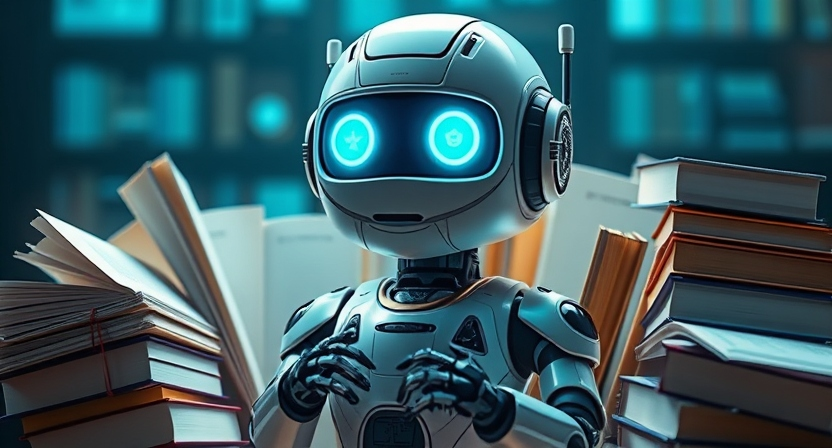

**Standard RAG** is a hybrid framework that integrates **retrieval techniques** with **generative models** to provide contextually accurate and informed responses. It works by retrieving relevant information from a pre-indexed knowledge base and using it as a foundation for a language model to generate precise, natural-sounding outputs.

## **Key Components**
1. **Retriever**: Searches and retrieves the most relevant information from the knowledge base.
2. **Generator**: Processes the retrieved context to generate coherent and accurate answers.



### **Key Highlights:**
- Combines **retrieval** with **large language models (LLMs)** for contextually accurate and detailed responses.
- Breaks documents into chunks for efficient indexing and retrieval.
- Ideal for applications requiring fast and reliable responses, like **chatbots**, **search engines**, and **customer support systems**.



## **How Standard RAG Works**



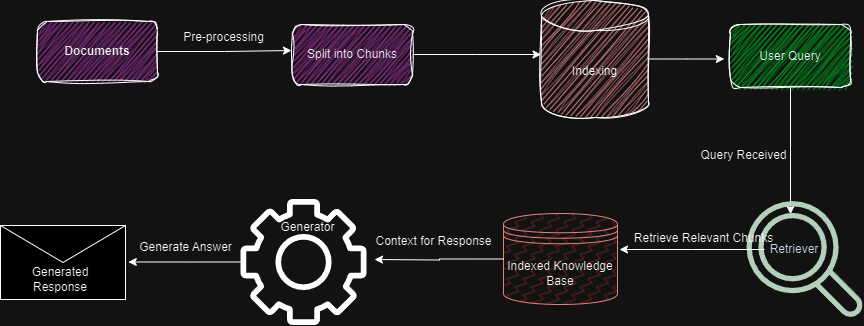

### **Step 1: Offline Preparation**
- **Pre-processing**: The documents are first cleaned and pre-processed to remove unnecessary data (such as stop words, punctuation, or irrelevant content). This step ensures that only relevant information is used in the next stages.
  
- **Chunking**: The processed documents are then split into smaller, manageable chunks. These chunks are typically small passages or paragraphs, making it easier to retrieve the relevant information later.
  
- **Indexing**: After chunking, the smaller pieces are indexed. This indexing process allows for fast and efficient searching of relevant chunks when a query is made. It acts like creating a table of contents for quicker access to information.



### **Step 2: Online Retrieval**
- **Query Reception**: When a query (or question) is made, the RAG system receives it and starts the retrieval process.
  
- **Relevance Matching**: The system identifies the most relevant chunks from the pre-processed, indexed documents using retrieval techniques. These methods include searching the index and ranking chunks based on their relevance to the query. This step ensures that the most pertinent information is retrieved to provide context for the response.


### **Step 3: Response Generation**
- **Context Understanding**: The retrieved chunks, which are the most relevant pieces of information, are used as context for the language model. The model uses this context to understand the query and the best way to respond.
  
- **Generating the Response**: Finally, the language model generates an accurate and informative response based on the context provided by the retrieved chunks. This step combines the power of the retrieval system and the generative capabilities of the language model to create a useful answer.


### Summary of How Standard RAG Works:
1. **Offline Preparation**: Documents are pre-processed, split into chunks, and indexed.
2. **Online Retrieval**: The system retrieves the most relevant chunks based on the query.
3. **Response Generation**: The language model uses the retrieved chunks to generate an accurate response.



In [3]:
!pip install -q pypdf2 groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 7.3 MB/s eta 0:00:00


In [4]:
import os
import requests
from PyPDF2 import PdfReader
from groq import Groq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# Set up the Groq client
client = Groq(api_key="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")

In [6]:
# Step 1: Download and Read the PDF
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # Example: BERT paper
pdf_path = "BERT_paper.pdf"

In [7]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)

In [8]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [9]:
# Step 2: Preprocess Text into Chunks
chunk_size = 1000
chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
print(f"Number of chunks created: {len(chunks)}")

Number of chunks created: 65


In [10]:
# Step 3: Convert Chunks into Embeddings (Simulating using TF-IDF)
vectorizer = TfidfVectorizer()
chunk_embeddings = vectorizer.fit_transform(chunks)

In [11]:
# Step 4: Retrieve Relevant Chunks for Query
query = "What is the importance of transformers in NLP?"

In [12]:
query_embedding = vectorizer.transform([query])
similarities = cosine_similarity(query_embedding, chunk_embeddings).flatten()

In [13]:
top_k = 3  # Retrieve top 3 most relevant chunks
top_chunk_indices = similarities.argsort()[-top_k:][::-1]
retrieved_chunks = [chunks[i] for i in top_chunk_indices]

In [14]:
# Step 5: Combine Retrieved Chunks and Pass to Groq Model
context = "\n\n".join(retrieved_chunks)
try:
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"Based on the following text: \n\n{context}\n\nAnswer the query: {query}"},
        ],
        model="llama3-8b-8192",  # Adjust to the model available in your Groq plan
    )
    # Extract and print the assistant's reply
    print("\n--- Response from Groq ---\n")
    print(response.choices[0].message.content)
except Exception as e:
    print(f"Error during query completion: {e}")


--- Response from Groq ---

According to the article, Transformers have become a common choice in Natural Language Processing (NLP) tasks, and the authors of BERT note that their implementation is almost identical to the original Transformer model. The Transformer architecture has been widely adopted due to its empirical power and simplicity. The BERT model itself is a pre-trained language representation model that uses bidirectional self-attention, which allows it to consider both the left and right context when generating its representations. This enables the model to perform well on a wide range of NLP tasks, such as question answering and language inference, without requiring substantial task-specific architecture modifications.

In summary, the importance of Transformers in NLP lies in their ability to be used as a powerful and flexible language representation model, which can be fine-tuned for a variety of NLP tasks.


In [15]:
def get_answer(query):
  query_embedding = vectorizer.transform([query])
  similarities = cosine_similarity(query_embedding, chunk_embeddings).flatten()

  top_chunk_indices = similarities.argsort()[-top_k:][::-1]
  retrieved_chunks = [chunks[i] for i in top_chunk_indices]

  context = "\n\n".join(retrieved_chunks)
  try:
      response = client.chat.completions.create(
          messages=[
              {"role": "system", "content": "You are a helpful assistant."},
              {"role": "user", "content": f"Based on the following text: \n\n{context}\n\nAnswer the query: {query}"},
          ],
          model="llama3-8b-8192",  # Adjust to the model available in your Groq plan
      )
      # Extract and print the assistant's reply
      print("\n--- Response from Groq ---\n")
      print(response.choices[0].message.content)
  except Exception as e:
      print(f"Error during query completion: {e}")

In [16]:
query = "What is the document about?"
get_answer(query=query)


--- Response from Groq ---

The document appears to be about natural language processing (NLP) and artificial intelligence (AI), specifically discussing various techniques and models for transforming machine learning algorithms and word embeddings to improve language understanding and generation.

The document appears to be a research paper or a technical report, as it presents various concepts, architectures, and algorithms used in NLP, such as ELMo, BERT, and other contextual word embedding models. The document also discusses their applications, performances, and limitations in various NLP tasks, including question answering, sentiment analysis, named entity recognition, and text generation.

The document is written in a formal, technical tone, with citations of related research papers and academic publications.


In [18]:
query = "explain the document clealry"
get_answer(query=query)


--- Response from Groq ---

The document discusses the advancements in Natural Language Processing (NLP) and the development of various techniques to improve the performance of language models. The main focus is on the use of contextual word embeddings and the fine-tuning of pre-trained language models, such as ELMo and BERT, for specific NLP tasks.

The document first introduces ELMo, which is a feature-based approach that combines the strengths of simple recurrent networks (SRNs) and bidirectional long short-term memory (LSTM) networks. ELMo is capable of producing contextualized word representations that improve the performance of various NLP benchmarks, including question answering, sentiment analysis, and named entity recognition.

The document then discusses unsupervised fine-tuning approaches, which involve pre-training word embeddings from unlabeled text and then fine-tuning them using labeled data. This approach was first proposed in Collobert and Weston (2008).

The main foc

## Explanation

#### Import Libraries
- Import necessary libraries for file handling, downloading data, processing text, and interacting with AI APIs.

#### Set Up Groq Client
- Initialize the Groq client using an API key for API communication.

#### Download and Read PDF
- Use `requests` to download a PDF from a URL.
- Save the PDF locally and extract its text using `PdfReader`.

#### Preprocess Text into Chunks
- Split the extracted text into smaller, manageable chunks of a fixed size (1000 characters) to improve processing efficiency.

#### Convert Chunks into Embeddings
- Apply TF-IDF to convert text chunks into numerical embeddings for comparing their relevance to the query.

#### Retrieve Relevant Chunks
- Compute cosine similarity between the query and text chunks.
- Identify and retrieve the top `k` chunks that are most relevant to the query.

#### Combine Chunks and Query Groq Model
- Merge the selected chunks into a single context.
- Send the context and query to the Groq AI model to generate a relevant response.

#### Handle Errors
- Implement error handling to capture and display issues during the API interaction.


## Applications of Standard RAG



- **Chatbots**: Enhance customer service by retrieving accurate information.
- **Search Engines**: Deliver personalized search results.
- **Education**: Answer complex questions with detailed responses.

## Limitations of Standard RAG



1. **Requires Well-Prepared Knowledge Bases**: RAG systems need well-structured and relevant data. For example, outdated or poorly categorized information can lead to incorrect responses.

2. **Dependent on the Quality of Indexed Data**: The accuracy of responses relies on the quality of indexed documents. If the data contains misinformation, the generated answers will also be flawed.

3. **Lack of Iterative Reasoning Capabilities**: RAG systems may struggle to connect retrieved information to specific user contexts. For instance, they might provide general regulations without relating them to a user's specific project.

4. **Computational Cost and Complexity**: Implementing RAG can be resource-intensive, leading to slower response times and higher operational costs, especially with large datasets.

5. **Contextual Limitations**: RAG may have difficulty understanding context if relevant documents are not well-linked, resulting in less coherent responses.

## Conclusion

Standard RAG bridges the gap between information retrieval and natural language generation. It’s a versatile framework with potential applications in diverse fields, enhancing the accuracy and relevance of responses in systems such as chatbots, search engines, and educational tools. As RAG continues to evolve, it promises to improve user interactions by providing timely and contextually appropriate information.

In the next section, we will discuss **Corrective RAG**, which builds upon the principles of Standard RAG. While Standard RAG focuses on retrieving and generating responses, Corrective RAG aims to enhance the accuracy and reliability of information by addressing potential inaccuracies in the knowledge base.